In [1]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import fdrcorrection
import pandas as pd
import numpy as np
import geopy.distance
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.colors import ListedColormap

# NTI distribution

## Ecotypes

In [2]:
df_all=pd.read_csv("../../Input/NTI_all.csv")
df_abun=pd.read_csv("../../Input/NTI_abun.csv")
df_gen=pd.read_csv("../../Input/NTI_gen.csv")
df_rare=pd.read_csv("../../Input/NTI_rare.csv")
df_spe=pd.read_csv("../../Input/NTI_spe.csv")

In [3]:
# Merging all ecotypes

merged_df = pd.merge(df_all, df_abun, on="Sample ID")
merged_df = pd.merge(merged_df, df_gen, on="Sample ID")
merged_df = pd.merge(merged_df, df_rare, on="Sample ID")
merged_df = pd.merge(merged_df, df_spe, on="Sample ID")

merged_df = merged_df.rename(columns={"NTI_all": "All", "NTI_abun": "Abundant", "NTI_gen": "Generalist", "NTI_rare": "Rare", "NTI_spe": "Specialist"})
merged_df = merged_df.reindex(columns=['Sample ID', 'All', 'Abundant', 'Rare', 'Generalist', 'Specialist'])

In [4]:
# Note:
# Use the output of the NTI R script as the input for this cell
# Group NTI values into 3 bins: <-2, >= -2 or <= 2, > 2

df_NTI = merged_df

xvar = df_NTI.columns
yvar = ('less2','btwn2','more2')

NTI_groups_temp = []
NTI_groups={}
for x in xvar:
    less2 = []
    btwn2 = []
    more2 = []
    if x!='Sample ID':
        for sample in range(len(df_NTI[x])):
        #print(df_NTI['Sample ID'][sample])
            if df_NTI[x][sample] < -2:
                less2.append(df_NTI['Sample ID'][sample])
            elif df_NTI[x][sample] >= -2 and df_NTI[x][sample] <= 2:
                btwn2.append(df_NTI['Sample ID'][sample])
            elif df_NTI[x][sample] > 2:
                more2.append(df_NTI['Sample ID'][sample])
        if x in ['NTI_all','NTI_abun', 'NTI_gen', 'NTI_rare', 'NTI_spe']:
            NTI_groups_temp.append([less2, btwn2, more2])
        NTI_groups[x]=[less2, btwn2, more2]

In [5]:
# Find counts of NTI bins

NTI_group_count = []

for group in NTI_groups.keys():
    counter = []
    for bin in NTI_groups[group]:
        counter.append(len(bin))
    NTI_group_count.append(counter)

df_NTI_group_count = pd.DataFrame(NTI_group_count)
df_NTI_group_count.rename(columns={0: "NTI < -2", 1: "-2 <= NTI <= 2", 2: "NTI > 2"},inplace=True)

In [6]:
df_NTI_group_count['All_Variables']=list(NTI_groups.keys())
df_NTI_group_count=df_NTI_group_count.set_index("All_Variables")

In [7]:
# NTI Counts

df_NTI_percent = df_NTI_group_count
df_NTI_percent[["NTI < -2", "-2 <= NTI <= 2", "NTI > 2"]] = df_NTI_group_count[["NTI < -2", "-2 <= NTI <= 2", "NTI > 2"]].apply(lambda x: x/x.sum()*100, axis=1)

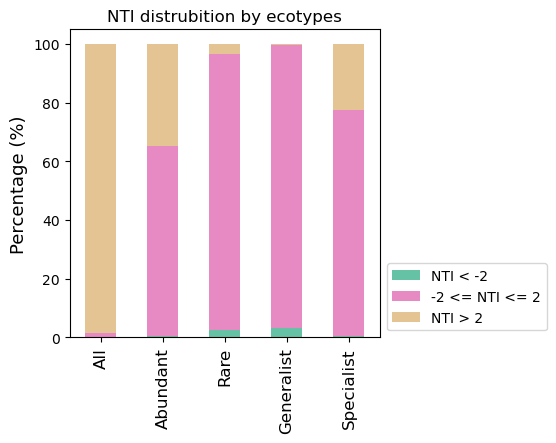

In [13]:
#Plot NTI bins

ax=df_NTI_percent[:5].plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("Set2", 7)))

plt.rcParams['figure.figsize'] = [4, 4]

plt.title('NTI distrubition by ecotypes', size=12)
plt.ylabel('Percentage (%)', size=13)
plt.xlabel('')
plt.xticks(fontsize=12, rotation=90)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0), fontsize = 10)
plt.savefig('../output/NTI_ecotypes.pdf', format='pdf', bbox_inches='tight', dpi=800)
plt.show()

## Ecosystems

In [14]:
df_all=pd.read_csv("../../Input/NTI_all.csv")
eco = pd.read_csv("../../Input/ecosystem.csv")

merged_df = pd.merge(df_all, eco, on="Sample ID")
merged_df = merged_df[merged_df["Ecosystem_recode"].str.contains("Unknown") == False]

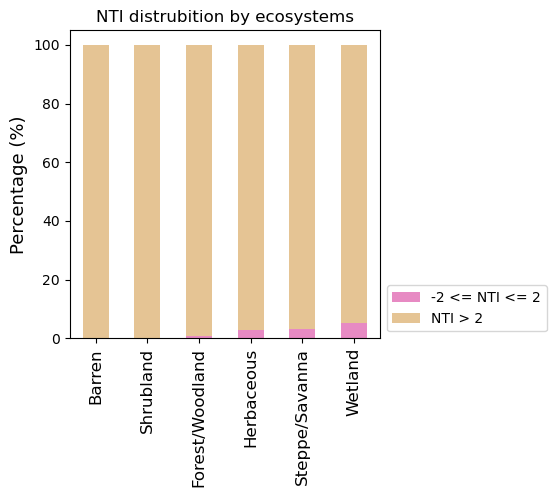

In [15]:
# Define the categories

def categorize(value):
    if value < -2:
        return 'NTI < -2'
    elif -2 <= value <= 2:
        return '-2 <= NTI <= 2'
    else:
        return 'NTI > 2'

merged_df['Category'] = merged_df['NTI_all'].apply(categorize)

# Calculate the percentage of each category within each ecosystem
category_percentage = merged_df.groupby(['Ecosystem_recode', 'Category']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack().fillna(0)
category_percentage = category_percentage.droplevel(0)
category_percentage = category_percentage.sort_values(by=['-2 <= NTI <= 2'])

# Plotting

palette = sns.color_palette("Set2")
four_color = palette[3]
seven_color = palette[6]


ax=category_percentage.plot(kind='bar', stacked=True, colormap=ListedColormap([four_color, seven_color]))

plt.rcParams['figure.figsize'] = [4, 4]

plt.title('NTI distrubition by ecosystems', size=12)
plt.ylabel('Percentage (%)', size=13)
plt.xlabel('')
plt.xticks(fontsize=12, rotation=90)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0), fontsize = 10)
plt.savefig('../output/NTI_ecosystems.pdf', format='pdf', bbox_inches='tight', dpi=800)
plt.show()

# BNTI distribution

In [54]:
# BNTI files preprocessing

def preprocess_file(df_taxa,taxanomy):

    #Loading and Melting BNTI all

    df_taxa['Samples']=df_taxa.columns
    df_taxa=df_taxa.melt(id_vars=['Samples'],value_vars=df_taxa.columns[1:])
    df_taxa=df_taxa.rename(columns={'Samples':'Sample ID_x','variable':'Sample ID_y'})

    for i in range(0,len(df_taxa)):
        if(df_taxa.loc[i]['Sample ID_x']==df_taxa.loc[i]['Sample ID_y']):
            df_taxa=df_taxa.drop([i],axis=0)

    df_taxa=df_taxa.sort_values(by=['Sample ID_x', 'Sample ID_y'])
    df_taxa=df_taxa.rename(columns={'value':taxanomy})

    return df_taxa

In [55]:
# Loading and melting BNTI of generalist

df_gen=pd.read_csv("../../Input/BNTI_gen.csv", index_col = 0)
df_gen=preprocess_file(df_gen,'gen_value')

In [56]:
# Loading and melting BNTI of Rare

df_rare=pd.read_csv("../../Input/BNTI_rare.csv", index_col = 0)
df_rare=preprocess_file(df_rare,'rare_value')

In [57]:
# Loading and melting BNTI of specialist

df_spe=pd.read_csv("../../Input/BNTI_spe.csv", index_col = 0)
df_spe=preprocess_file(df_spe,'spe_value')

In [58]:
# Loading and melting BNTI of all OTUs

df_all=pd.read_csv("../../Input/BNTI_all.csv", index_col = 0)
df_all=preprocess_file(df_all,'all_value')

In [59]:
# Stratify BNTI by ecosystem
# Forest/Woodland
# Barren
# Wetland
# Shrubland
# Herbaceous
# Steppe/Savanna

eco = pd.read_csv("../../Input/ecosystem.csv")

forest = eco[eco['Ecosystem_recode'] == 'Forest/Woodland']
df_forest = df_all[df_all['Sample ID_x'].isin(forest['Sample ID']) & df_all['Sample ID_y'].isin(forest['Sample ID'])]

barren = eco[eco['Ecosystem_recode'] == 'Barren']
df_barren = df_all[df_all['Sample ID_x'].isin(barren['Sample ID']) & df_all['Sample ID_y'].isin(barren['Sample ID'])]

wetland = eco[eco['Ecosystem_recode'] == 'Wetland']
df_wetland = df_all[df_all['Sample ID_x'].isin(wetland['Sample ID']) & df_all['Sample ID_y'].isin(wetland['Sample ID'])]

shrubland = eco[eco['Ecosystem_recode'] == 'Shrubland']
df_shrubland = df_all[df_all['Sample ID_x'].isin(shrubland['Sample ID']) & df_all['Sample ID_y'].isin(shrubland['Sample ID'])]

herbaceous = eco[eco['Ecosystem_recode'] == 'Herbaceous']
df_herbaceous = df_all[df_all['Sample ID_x'].isin(herbaceous['Sample ID']) & df_all['Sample ID_y'].isin(herbaceous['Sample ID'])]

steppe = eco[eco['Ecosystem_recode'] == 'Steppe/Savanna']
df_steppe = df_all[df_all['Sample ID_x'].isin(steppe['Sample ID']) & df_all['Sample ID_y'].isin(steppe['Sample ID'])]

### Stochastic processes

In [60]:
def stochastic_process(df_taxa,taxanomy_value, df_rc_bray):
    df_stochastic=df_taxa.copy()
    df_stochastic=df_stochastic.set_index(['Sample ID_x', 'Sample ID_y'])

    #Applying the condition to take values between -2 and 2
    condition = (df_stochastic[[taxanomy_value]] >= -2) & (df_stochastic[[taxanomy_value]] <= 2)
    df_stochastic = df_stochastic[condition.all(axis=1)]
    df_stochastic=df_stochastic.reset_index()

    df_rc_bray=df_rc_bray.drop(columns=['Unnamed: 0'],axis=1)
    #Merging stochastic and RCBray dataframes
    rc_bray=pd.merge(df_rc_bray, df_stochastic, on=['Sample ID_x', 'Sample ID_y'])

    return rc_bray

In [61]:
df_abun_stochastic=df_abun.copy()
df_spe_stochastic=df_spe.copy()
df_gen_stochastic=df_gen.copy()
df_rare_stochastic=df_rare.copy()

In [62]:
df_all_stochastic=df_all.copy()

df_forest_stochastic=df_forest.copy()
df_barren_stochastic=df_barren.copy()
df_wetland_stochastic=df_wetland.copy()
df_shrubland_stochastic=df_shrubland.copy()
df_herbaceous_stochastic=df_herbaceous.copy()
df_steppe_stochastic=df_steppe.copy()

In [63]:
#Loading all the RCBray results

df_bray_curtis_abun=pd.read_csv('../../Input/RCbray_abun.csv')
df_bray_curtis_gen=pd.read_csv('../../Input/RCbray_gen.csv')
df_bray_curtis_rare=pd.read_csv('../../Input/RCbray_rare.csv')
df_bray_curtis_spe=pd.read_csv('../../Input/RCbray_spe.csv')

In [64]:
df_bray_curtis_all=pd.read_csv('../../Input/RCbray_all.csv')

In [65]:
eco = pd.read_csv("../../Input/ecosystem.csv")

forest = eco[eco['Ecosystem_recode'] == 'Forest/Woodland']
df_bray_curtis_forest = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(forest['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(forest['Sample ID'])]

barren = eco[eco['Ecosystem_recode'] == 'Barren']
df_bray_curtis_barren = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(barren['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(barren['Sample ID'])]

wetland = eco[eco['Ecosystem_recode'] == 'Wetland']
df_bray_curtis_wetland = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(wetland['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(wetland['Sample ID'])]

shrubland = eco[eco['Ecosystem_recode'] == 'Shrubland']
df_bray_curtis_shrubland = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(shrubland['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(shrubland['Sample ID'])]

herbaceous = eco[eco['Ecosystem_recode'] == 'Herbaceous']
df_bray_curtis_herbaceous = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(herbaceous['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(herbaceous['Sample ID'])]

steppe = eco[eco['Ecosystem_recode'] == 'Steppe/Savanna']
df_bray_curtis_steppe = df_bray_curtis_all[df_bray_curtis_all['Sample ID_x'].isin(steppe['Sample ID']) & df_bray_curtis_all['Sample ID_y'].isin(steppe['Sample ID'])]

In [66]:
rc_bray_abun=stochastic_process(df_abun_stochastic,'abun_value', df_bray_curtis_abun)
rc_bray_spe=stochastic_process(df_spe_stochastic,'spe_value', df_bray_curtis_spe)
rc_bray_gen=stochastic_process(df_gen_stochastic,'gen_value', df_bray_curtis_gen)
rc_bray_rare=stochastic_process(df_rare_stochastic,'rare_value', df_bray_curtis_rare)

rc_bray_all=stochastic_process(df_all_stochastic,'all_value', df_bray_curtis_all)

rc_bray_forest=stochastic_process(df_forest_stochastic,'all_value', df_bray_curtis_forest)
rc_bray_barren=stochastic_process(df_barren_stochastic,'all_value', df_bray_curtis_barren)
rc_bray_wetland=stochastic_process(df_wetland_stochastic,'all_value', df_bray_curtis_wetland)
rc_bray_shrubland=stochastic_process(df_shrubland_stochastic,'all_value', df_bray_curtis_shrubland)
rc_bray_herbaceous=stochastic_process(df_herbaceous_stochastic,'all_value', df_bray_curtis_herbaceous)
rc_bray_steppe=stochastic_process(df_steppe_stochastic,'all_value', df_bray_curtis_steppe)

### Deterministic Processes

In [67]:
def deterministic_processes(df_taxa, taxanomy_value):
    df_deterministic=df_taxa.copy()
    df_deterministic=df_deterministic.set_index(['Sample ID_x', 'Sample ID_y'])

    #Applying conditions so as to separate into heterogeneous group (values > 2) and homogeneous group (values < -2)
    condition_deterministic_hetro = (df_deterministic[[taxanomy_value]] > 2)
    df_deterministic_hetero = df_deterministic[condition_deterministic_hetro.all(axis=1)]
    condition_deterministic_homo = (df_deterministic[[taxanomy_value]] < -2)
    df_deterministic_homo = df_deterministic[condition_deterministic_homo.all(axis=1)]

    df_deterministic_hetero=df_deterministic_hetero.reset_index()
    df_deterministic_homo=df_deterministic_homo.reset_index()

    return (df_deterministic_hetero,df_deterministic_homo)

In [68]:
df_abun_deterministic=df_abun.copy()
df_spe_deterministic=df_spe.copy()
df_gen_deterministic=df_gen.copy()
df_rare_deterministic=df_rare.copy()

In [69]:
df_all_deterministic=df_all.copy()

df_forest_deterministic=df_forest.copy()
df_barren_deterministic=df_barren.copy()
df_wetland_deterministic=df_wetland.copy()
df_shrubland_deterministic=df_shrubland.copy()
df_herbaceous_deterministic=df_herbaceous.copy()
df_steppe_deterministic=df_steppe.copy()

In [70]:
df_abun_deterministic_hetero,df_abun_deterministic_homo=deterministic_processes(df_abun_deterministic,'abun_value')
df_spe_deterministic_hetero,df_spe_deterministic_homo=deterministic_processes(df_spe_deterministic,'spe_value')
df_gen_deterministic_hetero,df_gen_deterministic_homo=deterministic_processes(df_gen_deterministic,'gen_value')
df_rare_deterministic_hetero,df_rare_deterministic_homo=deterministic_processes(df_rare_deterministic,'rare_value')

df_all_deterministic_hetero,df_all_deterministic_homo=deterministic_processes(df_all_deterministic,'all_value')

df_forest_deterministic_hetero,df_forest_deterministic_homo=deterministic_processes(df_forest_deterministic,'all_value')
df_barren_deterministic_hetero,df_barren_deterministic_homo=deterministic_processes(df_barren_deterministic,'all_value')
df_wetland_deterministic_hetero,df_wetland_deterministic_homo=deterministic_processes(df_wetland_deterministic,'all_value')
df_shrubland_deterministic_hetero,df_shrubland_deterministic_homo=deterministic_processes(df_shrubland_deterministic,'all_value')
df_herbaceous_deterministic_hetero,df_herbaceous_deterministic_homo=deterministic_processes(df_herbaceous_deterministic,'all_value')
df_steppe_deterministic_hetero,df_steppe_deterministic_homo=deterministic_processes(df_steppe_deterministic,'all_value')

### Pie chart for all taxa, ecotypes, and ecosystems

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import rcParams

def plot_pie_chart(df_deterministic_hetero, df_deterministic_homo, rc_bray, taxanomy):

    deterministic_hetero_size = len(df_deterministic_hetero)
    deterministic_homo_size = len(df_deterministic_homo)
    dispersal_limitation_size = len(rc_bray[rc_bray['RCbray'] > 0.95])
    homogenizing_dispersal_size = len(rc_bray[rc_bray['RCbray'] < -0.95])
    drift_size = len(rc_bray[(rc_bray['RCbray'] >= -0.95) & (rc_bray['RCbray'] <= 0.95)])

    # plt.rcParams["figure.figsize"] = (6, 6)
    fig, ax = plt.subplots()
    ax.axis('equal')


    outer_sizes = [deterministic_hetero_size + deterministic_homo_size, dispersal_limitation_size + homogenizing_dispersal_size + drift_size]
    outer_colors = ['#CD6155', '#5499C7']
    outer_wedgeprops = {'width': 0.5}  # Adjust the width for the outer circle
    _, _ = ax.pie(outer_sizes, colors=outer_colors, wedgeprops=outer_wedgeprops, startangle=90, counterclock=False)


    inner_sizes = [deterministic_hetero_size, deterministic_homo_size, dispersal_limitation_size, homogenizing_dispersal_size, drift_size]
    inner_labels = ['Heterogeneous Selection', 'Homogeneous Selection', 'Dispersal Limitation', 'Homogenizing Dispersal', 'Drift']
    inner_colors = ['#E59866', '#F1C40F', '#C39BD3', '#85C1E9', '#73C6B6']
    _, _ = ax.pie(inner_sizes, colors=inner_colors, radius=0.5, startangle=90, counterclock=False, textprops={'fontsize': 10})


    all_outer_labels = ['Deterministic Process', 'Stochastic Process']
    all_outer_colors = ['#CD6155', '#5499C7']
    all_inner_labels = ['Heterogeneous Selection', 'Homogeneous Selection', 'Dispersal Limitation', 'Homogenizing Dispersal', 'Drift']
    all_inner_colors = ['#E59866', '#F1C40F', '#C39BD3', '#85C1E9', '#73C6B6']
    color_patches_outer = [mpatches.Patch(color=color, label=label) for color, label in zip(all_outer_colors, all_outer_labels)]
    color_patches_inner = [mpatches.Patch(color=color, label=label) for color, label in zip(all_inner_colors, all_inner_labels)]
    ax.legend(handles=color_patches_outer + color_patches_inner, bbox_to_anchor=(1, 0.6))

    plt.rcParams['figure.figsize'] = [6, 6]
    ax.set_title(taxanomy,fontsize=14, y=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig('../output/'+taxanomy+'.'+'pdf', bbox_inches='tight', dpi=600)
    plt.show()

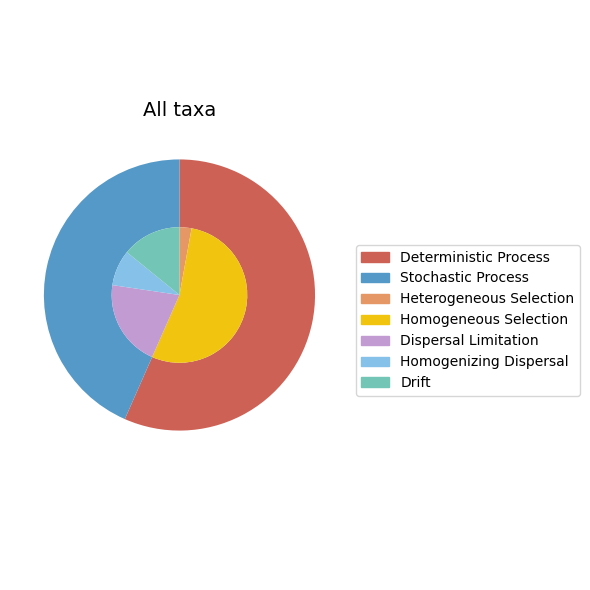

In [72]:
plot_pie_chart(df_all_deterministic_hetero,df_all_deterministic_homo, rc_bray_all, 'All taxa')

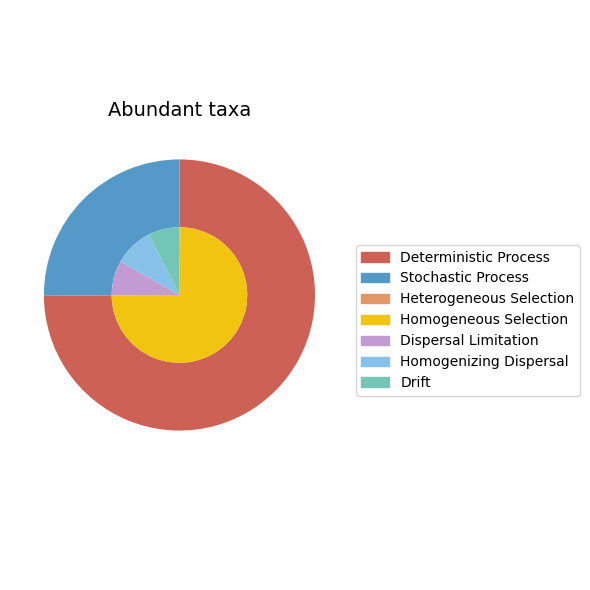

In [73]:
plot_pie_chart(df_abun_deterministic_hetero,df_abun_deterministic_homo, rc_bray_abun, 'Abundant taxa')

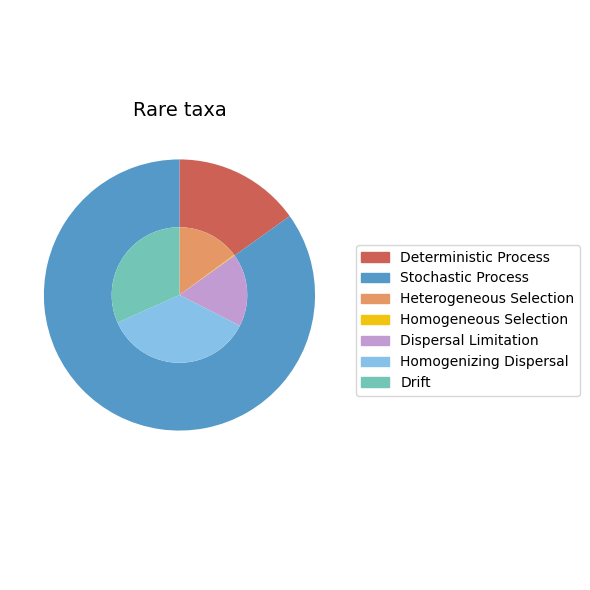

In [74]:
plot_pie_chart(df_rare_deterministic_hetero,df_rare_deterministic_homo, rc_bray_rare, 'Rare taxa')

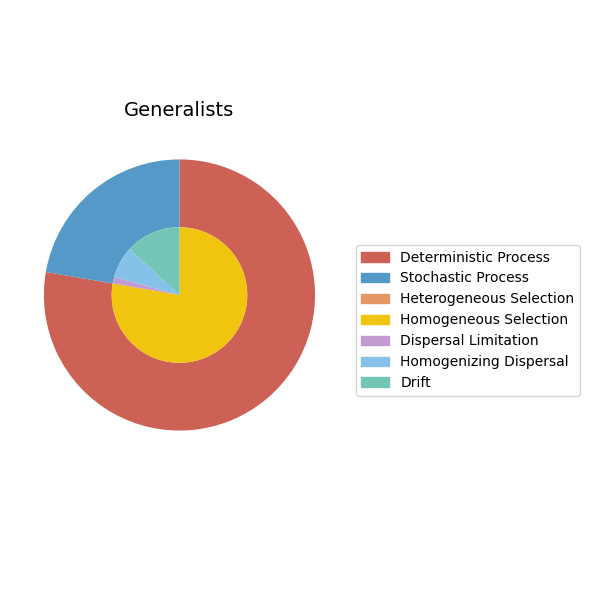

In [75]:
plot_pie_chart(df_gen_deterministic_hetero,df_gen_deterministic_homo, rc_bray_gen, 'Generalists')

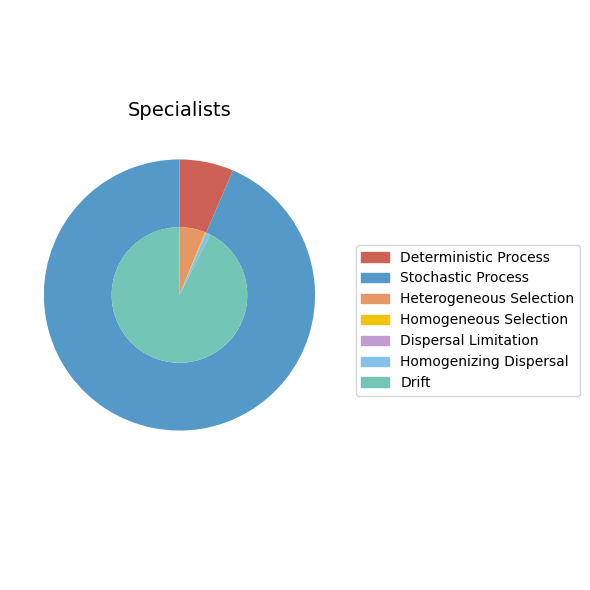

In [76]:
plot_pie_chart(df_spe_deterministic_hetero,df_spe_deterministic_homo, rc_bray_spe, 'Specialists')

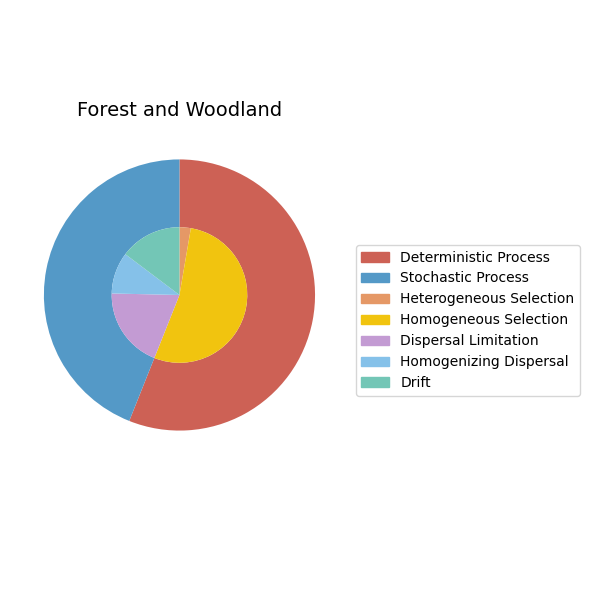

In [77]:
plot_pie_chart(df_forest_deterministic_hetero,df_forest_deterministic_homo, rc_bray_forest, 'Forest and Woodland')

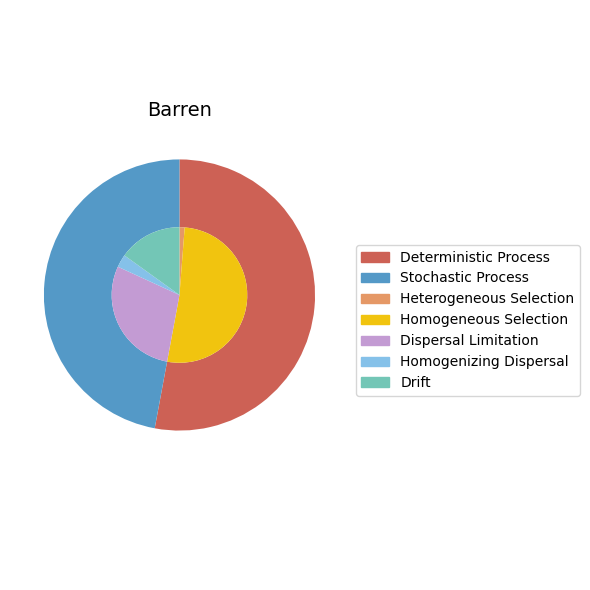

In [78]:
plot_pie_chart(df_barren_deterministic_hetero,df_barren_deterministic_homo, rc_bray_barren, 'Barren')

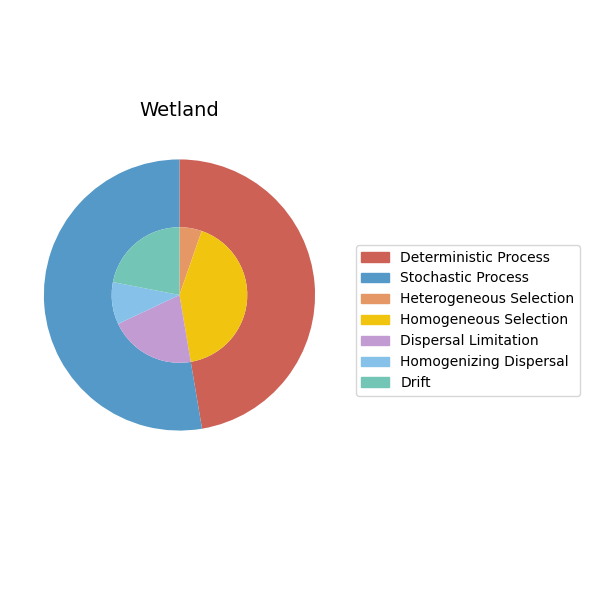

In [79]:
plot_pie_chart(df_wetland_deterministic_hetero,df_wetland_deterministic_homo, rc_bray_wetland, 'Wetland')

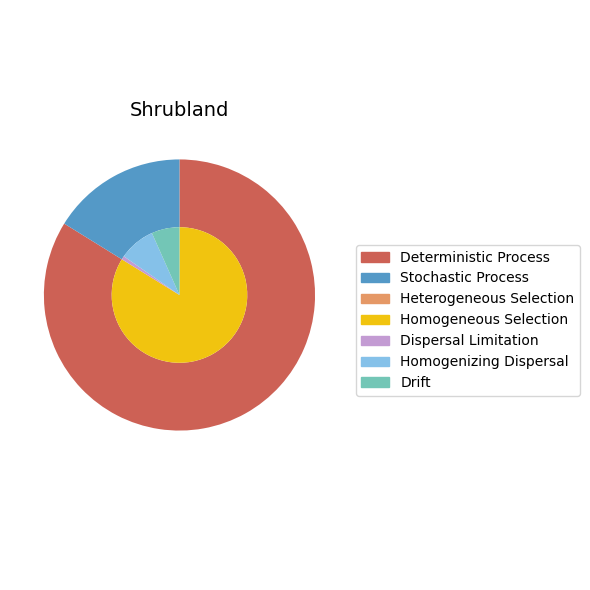

In [80]:
plot_pie_chart(df_shrubland_deterministic_hetero,df_shrubland_deterministic_homo, rc_bray_shrubland, 'Shrubland')

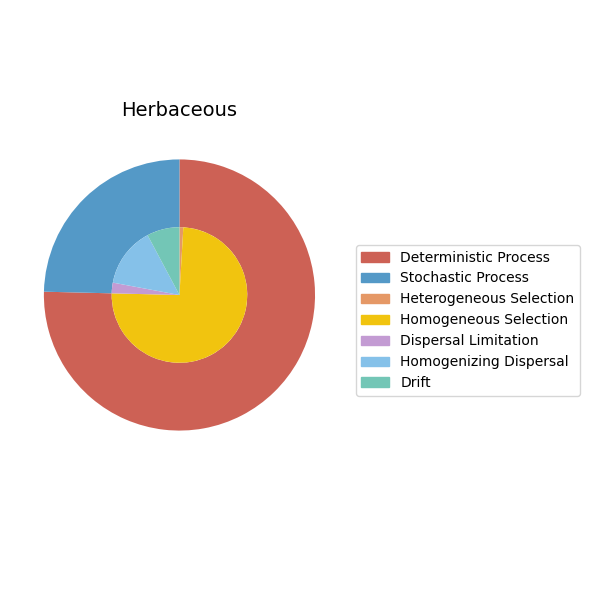

In [81]:
plot_pie_chart(df_herbaceous_deterministic_hetero,df_herbaceous_deterministic_homo, rc_bray_herbaceous, 'Herbaceous')

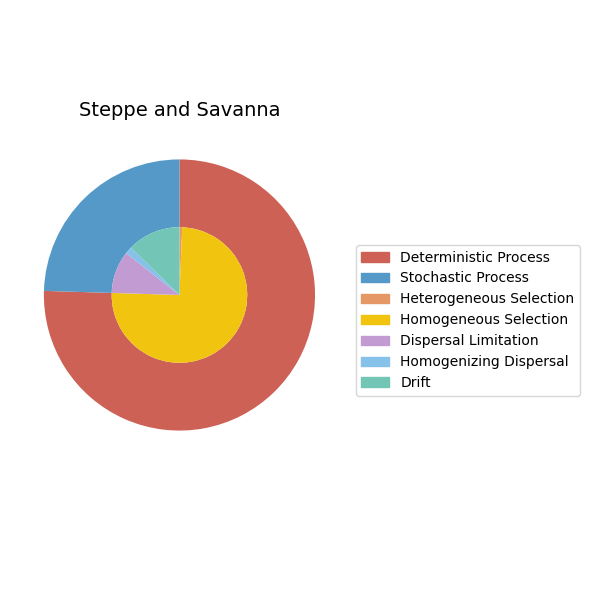

In [82]:
plot_pie_chart(df_steppe_deterministic_hetero,df_steppe_deterministic_homo, rc_bray_steppe, 'Steppe and Savanna')